# 9 Black-Scholes and Real-World Data

**Fall 2025 Quantiative Methods in Finance**

**The Erdös Institute**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import datetime as datetime
import yfinance as yf

#Statistical tests for normality and autocorrelation
from scipy.stats import normaltest
from statsmodels.stats.diagnostic import acorr_ljungbox


sns.set_style('darkgrid')

In [2]:
## Randomly generated stock paths as Geometric Brownian Motions

def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    """Simulates stock paths as geometric Brownian Motions
    Inputs:
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in each simulated path, each step interval has length t/n_steps
    
    Return (np.array): Array of stock paths
    """
    
    dt = t/n_steps
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    log_returns = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise
    exponent = np.cumsum(log_returns, axis = 1)
    paths = S0*np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis = 1)

    return paths_with_start

##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    
    
    return call_value
    


def bs_put(S0, K, sigma, t, r):
    '''
    Black-Scholes Put Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of put option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    put_value = -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)
    
    
    return put_value


def bs_call_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Call Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call option with respect to S_0
    
    '''
    
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return norm.cdf(d1)



def bs_put_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Put Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of put option with respect to S_0
    
    '''
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return -1 + norm.cdf(d1)


def bs_vega(S0, K, sigma, t, r):
    '''Black-Scholes vega of Call & Put Options
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call & put option with respect to sigma
    
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return S0*norm.pdf(d1)*np.sqrt(t)

In [3]:
#Monte-Carlo Simulation of call option with hedging profits

def bs_MC_call(S0, K, sigma, t, r, mu, n_sims, n_hedges, return_distribution = True):
    
    '''Monte-Carlo Simulation of Call option value with Black-Scholes Assumptions
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free Interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): Number of Delta hedges
    
    
    Return:
    If return_distribution is True, returns distribution of simulated call values with delta hedging
    
    If return_distribution is False, returns the average payoff of call option with delta hedging
    
    To simulate profit distribution of selling n_options number of call options for a premimum, run
    
    n_options*(premium - bs_MC_call(S0, K, sigma, t, r, mu, n_sims, n_hedges))
    
    '''
    
    
    # 0 Delta Hedges
    if n_hedges == 0:
        
        stock_path_endpoints = GBM_paths(S0,sigma, t, r, mu, n_sims, 1)[:,-1]
        
        call_payout_discounted = np.maximum(stock_path_endpoints-K,0)
        
        if return_distribution:
            
            return call_payout_discounted
        
        else:
            return np.mean(call_payout_discounted)
        
    # Delta Hedges
    else:

        stock_paths = GBM_paths(S0,sigma, t, r, mu, n_sims, n_hedges)

        call_payout_discounted = np.maximum(stock_paths[:,-1] - K, 0)*np.exp(-r*t)

        times = np.linspace(0, t, n_hedges + 1)

        dt = t/n_hedges


        deltas = bs_call_delta(stock_paths[:,0:n_hedges], K, sigma, (t- times)[0:n_hedges], r)

        stock_profits_discounted = (stock_paths[:,1:n_hedges + 1] - \
                                    stock_paths[:,0:n_hedges]*np.exp(r*dt))*np.exp(-r*times[1:n_hedges+1])*deltas


        total_stock_profits = np.sum(stock_profits_discounted, axis = 1)


        profit_of_call_with_hedging = call_payout_discounted - total_stock_profits


        if return_distribution:
            
            return profit_of_call_with_hedging
        
        else:
            
            return np.mean(profit_of_call_with_hedging)




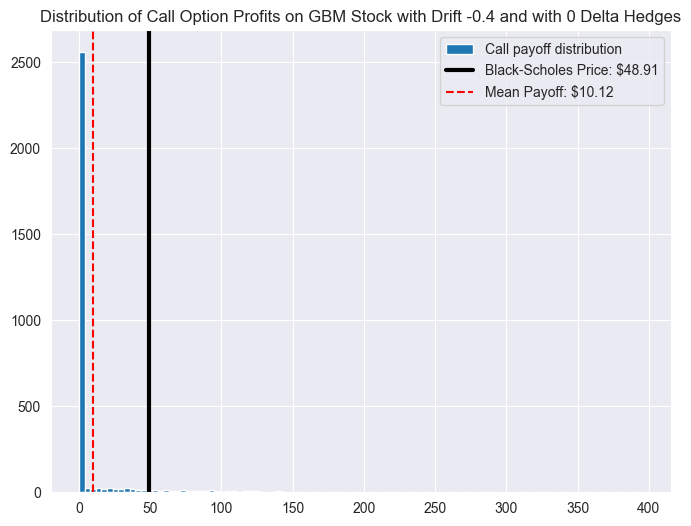

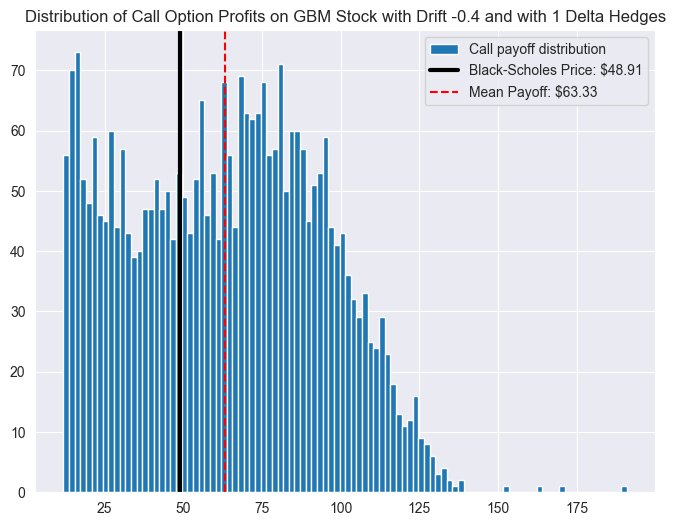

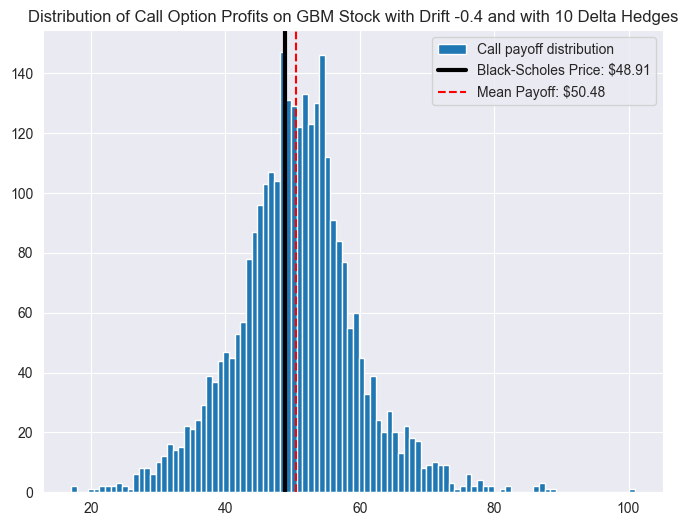

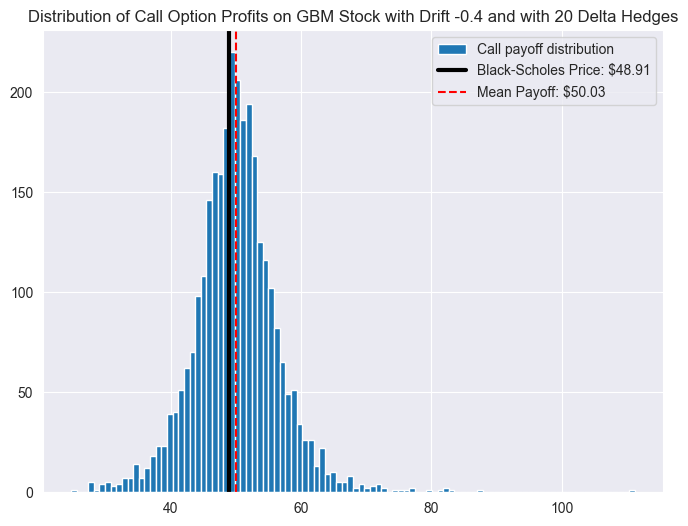

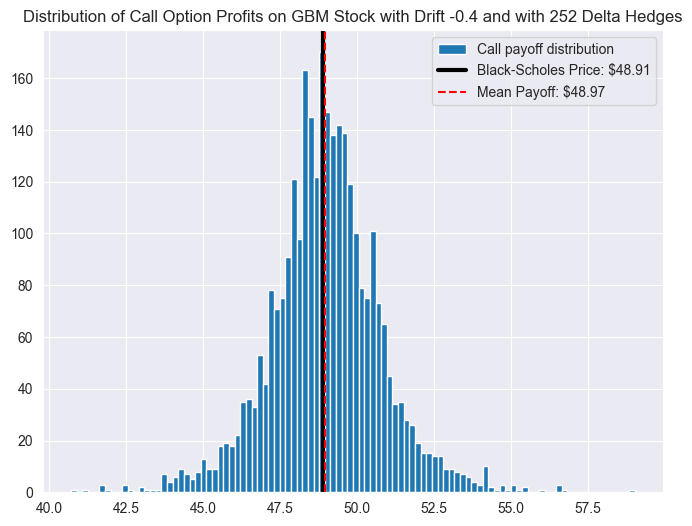

In [4]:
S0 = 250

K = 240

sigma = .41

t = 1

r = 0.035

mu = -.4

n_sims = 3000



hedging_amounts = [0, 1, 10, 20, 252]

for n_hedges in hedging_amounts:
    
    call_value_distribution = bs_MC_call(S0, K, sigma, t, r, mu, n_sims, n_hedges, return_distribution = True)
    
    simulated_call_price = np.mean(call_value_distribution)
    
    plt.figure(figsize = (8,6))
    
    plt.hist(call_value_distribution, bins = 100, label= 'Call payoff distribution')
    
    plt.axvline(bs_call(S0,K,sigma,t,r),\
                color = 'black', lw = 3, label = f'Black-Scholes Price: ${bs_call(S0,K,sigma,t,r):.2f}')
    
    plt.axvline(simulated_call_price, ls = '--',\
                color = 'red', label = f'Mean Payoff: ${simulated_call_price:.2f}')
    
    plt.title(f'Distribution of Call Option Profits on GBM Stock with Drift {mu} and with {n_hedges} Delta Hedges')
    plt.legend()
    plt.show()

In [5]:
#import stock data from yfinance

tickers = ['AAPL', 'TSLA', 'F', 'HD', 'GM', 'SPY', '^GSPC', 'VTI', 'QQQ']


stock_data = yf.download(tickers, interval = '1d', start = '2025-01-01', end = '2025-10-11')

stock_data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  9 of 9 completed


Price            Close                                                \
Ticker            AAPL          F         GM          HD         QQQ   
Date                                                                   
2025-01-02  242.987427   9.088185  50.944981  381.462158  508.309448   
2025-01-03  242.499161   9.304796  51.341671  382.169189  516.628052   
2025-01-06  244.133347   9.342467  53.087105  382.355774  522.565613   
2025-01-07  241.353226   9.191781  51.549934  377.308350  513.240784   
2025-01-08  241.841461   9.172946  50.578045  380.224854  513.330444   
...                ...        ...        ...         ...         ...   
2025-10-06  256.690002  12.700000  58.189999  389.329987  607.710022   
2025-10-07  256.480011  11.920000  57.259998  386.809998  604.510010   
2025-10-08  258.059998  11.740000  56.400002  383.790009  611.440002   
2025-10-09  254.039993  11.500000  55.919998  377.690002  610.700012   
2025-10-10  245.270004  11.410000  55.349998  375.750000  589.500000   

Price                                                              High  ...  \
Ticker             SPY        TSLA         VTI        ^GSPC        AAPL  ...   
Date                                                                     ...   
2025-01-02  579.561707  379.279999  286.582336  5868.549805  248.218856  ...   
2025-01-03  586.808167  410.440002  290.347137  5942.470215  243.316252  ...   
2025-01-06  590.188538  411.049988  291.971954  5975.379883  246.455106  ...   
2025-01-07  583.517029  394.359985  288.712433  5909.029785  244.681407  ...   
2025-01-08  584.369507  394.940002  288.979889  5918.250000  242.847898  ...   
...                ...         ...         ...          ...         ...  ...   
2025-10-06  671.609985  453.250000  331.209991  6740.279785  259.070007  ...   
2025-10-07  669.119995  433.089996  329.619995  6714.589844  257.399994  ...   
2025-10-08  673.109985  438.690002  331.809998  6753.720215  258.519989  ...   
2025-10-09  671.159973  435.540009  330.660004  6735.109863  258.000000  ...   
2025-10-10  653.020020  413.489990  321.799988  6552.509766  256.380005  ...   

Price              Open    Volume                                          \
Ticker            ^GSPC      AAPL          F        GM       HD       QQQ   
Date                                                                        
2025-01-02  5903.259766  55740700   67156200  10167700  2415700  36389800   
2025-01-03  5891.069824  40244100   77245900   8949900  2231600  29059500   
2025-01-06  5982.810059  45045600   63840800   9728200  3274500  36109700   
2025-01-07  5993.259766  40856000   62404000   9093300  2274300  36690300   
2025-01-08  5910.660156  37628900   61678800   7243700  2848500  30777800   
...                 ...       ...        ...       ...      ...       ...   
2025-10-06  6733.859863  44664100   90544900   8921500  3653700  41962100   
2025-10-07  6746.140137  31955800  154390200  10702900  2505700  58209500   
2025-10-08  6723.870117  36496900   78469700   5430000  2517600  50629800   
2025-10-09  6760.500000  38322000   70320500   5441800  3321400  45551000   
2025-10-10  6740.490234  61999100   84595400   5454400  2992400  97614800   

Price                                                  
Ticker            SPY       TSLA      VTI       ^GSPC  
Date                                                   
2025-01-02   50204000  109710700  3796400  3621680000  
2025-01-03   37888500   95423300  2726800  3667340000  
2025-01-06   47679400   85516500  3678600  4940120000  
2025-01-07   60393100   75699500  3317000  4517330000  
2025-01-08   47304700   73038800  2971300  4441740000  
...               ...        ...      ...         ...  
2025-10-06   54623300   85324900  4899400  5604460000  
2025-10-07   72020100  102296100  4956100  5546150000  
2025-10-08   60702200   71192100  3149300  5383130000  
2025-10-09   66501900   69339900  3803200  5385020000  
2025-10-10  159422600  112107900  7886700  5385020000  

[194 r

### Black-Scholes Assumptions


Black-Scholes assumes the following about a stock-path:

1) That a stock path has log-normal returns and log-returns over a period of time are independent of log-returns over a previous time.

2) Log-returns are normally distributed.

3) Volatility is constant.

In [6]:
#D'Aotino and Pearson's test for normality

#Null hypothesis: Data set is normally distributed

#small p-value (<.05) gives high significance that data is not normally distributed


#test of normaltest function on normally distributed data

normal_data = np.random.normal(size = 1500)

normaltest(normal_data)

NormaltestResult(statistic=0.029143135107614765, pvalue=0.9855340839448297)

In [8]:
#test of normaltest function on non-normally distributed data


non_normal_data = np.random.uniform(size = 150)

normaltest(non_normal_data)

NormaltestResult(statistic=27.107916657780528, pvalue=1.2989447824834453e-06)

In [10]:
#Investigate with real stock data if log-returns are normally distributed



for ticker in tickers:


    log_returns = np.log(stock_data['Close', ticker].pct_change()+1).dropna()


    stat, p = normaltest(log_returns)


    if p < .01:
        print(f'{ticker} log-return stat test p-value of test {p}: data likely not normally distributed')
        print('-'*100)

    else:
        print(f'{ticker} log-return stat test p-value of test {p}: data could be normally distributed')
        print('-'*100)

AAPL log-return stat test p-value of test 9.192581670553167e-14: data likely not normally distributed
----------------------------------------------------------------------------------------------------
TSLA log-return stat test p-value of test 1.165775148345627e-05: data likely not normally distributed
----------------------------------------------------------------------------------------------------
F log-return stat test p-value of test 4.667561004439135e-05: data likely not normally distributed
----------------------------------------------------------------------------------------------------
HD log-return stat test p-value of test 0.0007198050395210826: data likely not normally distributed
----------------------------------------------------------------------------------------------------
GM log-return stat test p-value of test 5.438513754525752e-06: data likely not normally distributed
---------------------------------------------------------------------------------------------

In [ ]:
#Investigate if log-return time series have autocorrelation


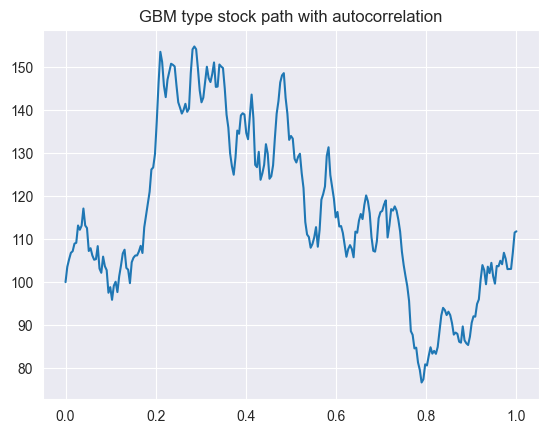

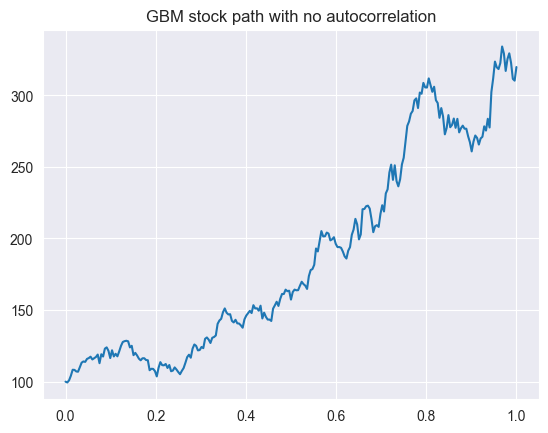

In [22]:
#Simulate stock path with autocorrelation

S0 = 100

sigma = .4

t = 1

r = 0.35

mu = 0

n_steps = 252

dt = t/n_steps

phi = .25

noise = np.random.normal(size = n_steps)

volatilities = np.zeros(n_steps)

volatilities[0] = np.sqrt(dt)*sigma*noise[0]

for i in range(1, n_steps):
    volatilities[i] = phi*volatilities[i-1] + np.sqrt(dt)*sigma*noise[i]
    

    
log_returns = (mu+r-sigma**2*(0.5))*dt + volatilities





exponent = np.cumsum(log_returns)

stock_path = S0*np.exp(exponent)


stock_path = np.insert(stock_path,0,S0)


times = np.linspace(0,t, n_steps+1)

plt.plot(times, stock_path)

plt.title(f'GBM type stock path with autocorrelation')
plt.show()



#Simulate stock path with autocorrelation

S0 = 100

sigma = .4

t = 1

r = 0.35

mu = 0

n_steps = 252

dt = t/n_steps

phi = .25

noise = np.random.normal(size = n_steps)


    
log_returns_no_correlation = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise





exponent = np.cumsum(log_returns_no_correlation)

stock_path = S0*np.exp(exponent)


stock_path = np.insert(stock_path,0,S0)


times = np.linspace(0,t, n_steps+1)

plt.plot(times, stock_path)

plt.title(f'GBM stock path with no autocorrelation')
plt.show()

In [14]:
help(acorr_ljungbox)

Help on function acorr_ljungbox in module statsmodels.stats.diagnostic:

acorr_ljungbox(x, lags=None, boxpierce=False, model_df=0, period=None, return_df=True, auto_lag=False)
    Ljung-Box test of autocorrelation in residuals.
    
    Parameters
    ----------
    x : array_like
        The data series. The data is demeaned before the test statistic is
        computed.
    lags : {int, array_like}, default None
        If lags is an integer then this is taken to be the largest lag
        that is included, the test result is reported for all smaller lag
        length. If lags is a list or array, then all lags are included up to
        the largest lag in the list, however only the tests for the lags in
        the list are reported. If lags is None, then the default maxlag is
        min(10, nobs // 5). The default number of lags changes if period
        is set.
    boxpierce : bool, default False
        If true, then additional to the results of the Ljung-Box test also the
     

In [15]:
#Ljung-Box Test with lag L

#Null hypothesis: Value of time series at n is uncorrelated with times series at time n-L
#Small p-value (<.05) corresponds to statistal significane there is correlation between value n and n-L

acorr_ljungbox(log_returns)

,lb_stat,lb_pvalue
1,9.893799,0.001658
2,11.009670,0.004067
3,12.708672,0.005311
4,13.985011,0.007343
5,14.003691,0.015586
6,15.179181,0.018908
7,15.780461,0.027200
8,17.931005,0.021750
9,20.743510,0.013839
10,22.354331,0.013398


In [16]:
acorr_ljungbox(log_returns_no_correlation)

,lb_stat,lb_pvalue
1,4.424037,0.035436
2,4.437639,0.108737
3,4.574697,0.205723
4,4.715361,0.317769
5,6.178489,0.289237
6,6.457879,0.373897
7,6.574303,0.474505
8,6.682734,0.571218
9,7.518617,0.583287
10,7.528186,0.674815


In [17]:
### Test if log-returns of stocks have autocorrelation

ticker = 'QQQ'

for ticker in tickers:

    log_returns = np.log(stock_data['Close', ticker].pct_change()+1).dropna()

    print(f'Ljung-Box test for {ticker}')
    display(acorr_ljungbox(log_returns, lags = 20))
    print('-'*100)

Ljung-Box test for AAPL


,lb_stat,lb_pvalue
1,0.351899,0.553040
2,5.120002,0.077305
3,7.418797,0.059682
4,11.310571,0.023287
5,14.046106,0.015319
6,14.121745,0.028305
7,15.936553,0.025702
8,16.261964,0.038780
9,16.275498,0.061347
10,17.118035,0.071793


----------------------------------------------------------------------------------------------------
Ljung-Box test for TSLA


,lb_stat,lb_pvalue
1,0.112313,0.737526
2,0.201365,0.904220
3,1.502488,0.681696
4,3.522909,0.474404
5,3.887622,0.565707
6,3.937543,0.685128
7,4.238435,0.751941
8,6.462533,0.595566
9,6.679190,0.670480
10,7.027392,0.722856


----------------------------------------------------------------------------------------------------
Ljung-Box test for F


,lb_stat,lb_pvalue
1,5.094230,0.024006
2,5.205783,0.074059
3,8.409958,0.038257
4,15.980555,0.003045
5,16.624844,0.005269
6,16.941872,0.009499
7,17.614721,0.013835
8,17.816518,0.022645
9,21.658879,0.010025
10,21.667839,0.016889


----------------------------------------------------------------------------------------------------
Ljung-Box test for HD


,lb_stat,lb_pvalue
1,2.388822,0.122206
2,2.459310,0.292393
3,5.520688,0.137406
4,8.014832,0.091036
5,8.324083,0.139256
6,9.560390,0.144428
7,10.873093,0.144251
8,11.473981,0.176261
9,12.730165,0.175201
10,13.363081,0.204074


----------------------------------------------------------------------------------------------------
Ljung-Box test for GM


,lb_stat,lb_pvalue
1,8.339115,0.003880
2,8.952733,0.011375
3,9.137745,0.027514
4,10.540356,0.032246
5,10.988431,0.051610
6,11.519300,0.073593
7,11.521375,0.117438
8,12.170793,0.143745
9,14.524490,0.104853
10,14.825973,0.138537


----------------------------------------------------------------------------------------------------
Ljung-Box test for SPY


,lb_stat,lb_pvalue
1,4.672299,0.030653
2,8.271951,0.015987
3,13.780145,0.003220
4,15.568303,0.003657
5,15.723756,0.007679
6,16.362532,0.011935
7,17.551593,0.014166
8,17.889502,0.022070
9,17.985867,0.035338
10,19.935683,0.029867


----------------------------------------------------------------------------------------------------
Ljung-Box test for ^GSPC


,lb_stat,lb_pvalue
1,2.457862,0.116938
2,6.164644,0.045853
3,12.201589,0.006724
4,14.337158,0.006293
5,14.380890,0.013363
6,15.065840,0.019751
7,16.008609,0.025038
8,16.480144,0.036001
9,16.601008,0.055343
10,18.696944,0.044285


----------------------------------------------------------------------------------------------------
Ljung-Box test for VTI


,lb_stat,lb_pvalue
1,3.371046,0.066352
2,6.259564,0.043727
3,11.034283,0.011542
4,12.918295,0.011682
5,13.212157,0.021470
6,14.044887,0.029139
7,15.121954,0.034468
8,15.377800,0.052203
9,15.505140,0.077963
10,17.675213,0.060696


----------------------------------------------------------------------------------------------------
Ljung-Box test for QQQ


,lb_stat,lb_pvalue
1,3.483202,0.061995
2,7.805819,0.020183
3,13.407629,0.003833
4,14.980884,0.004741
5,14.989814,0.010406
6,16.107449,0.013189
7,17.265857,0.015760
8,17.548428,0.024879
9,17.570227,0.040500
10,18.536969,0.046554


----------------------------------------------------------------------------------------------------


In [18]:
#Investigate if volatility is constant over different intervals of time
for ticker in tickers:

    stock_data['log_returns', ticker] = np.log(stock_data['Close', ticker].pct_change()+1)
    
    stock_data['volatility', ticker] = stock_data['log_returns', ticker].rolling(window = 42).std()*np.sqrt(252)

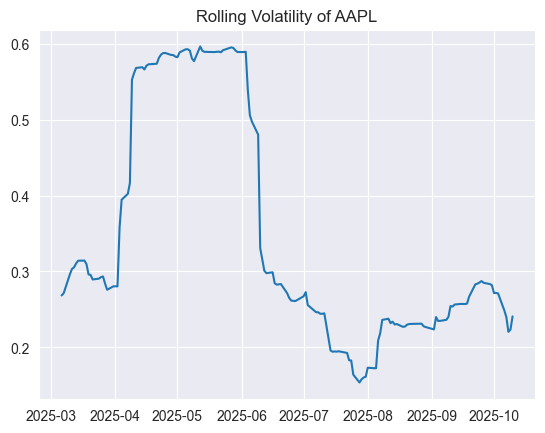

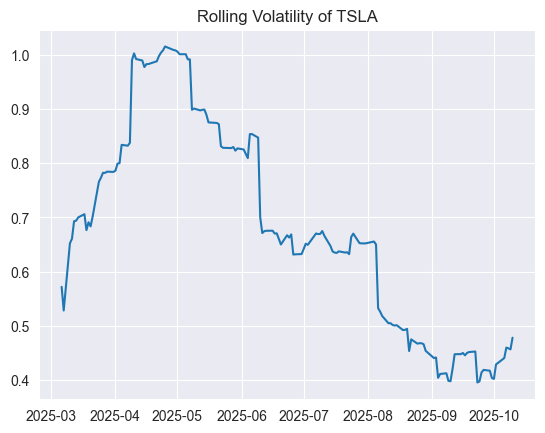

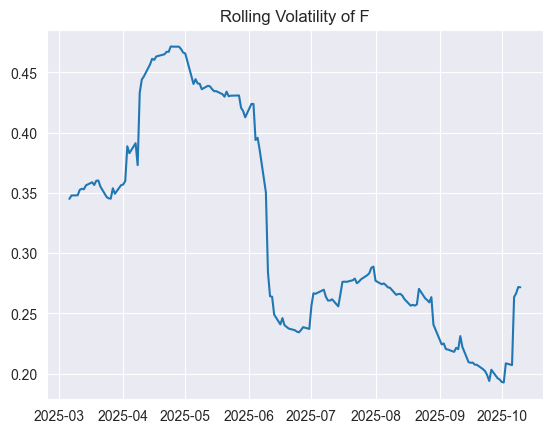

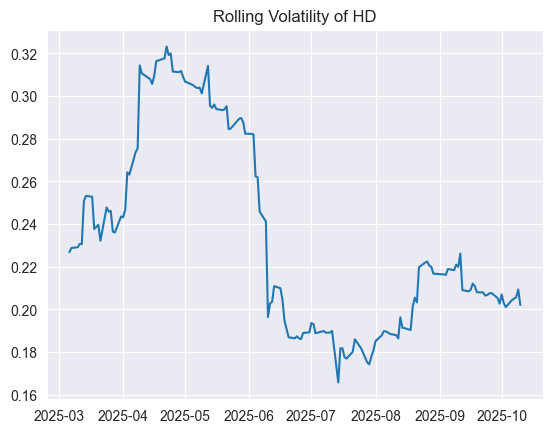

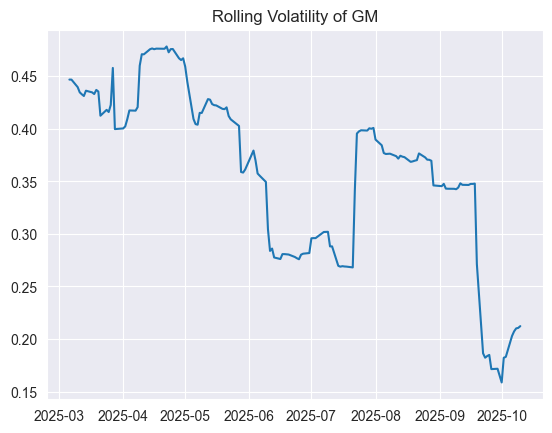

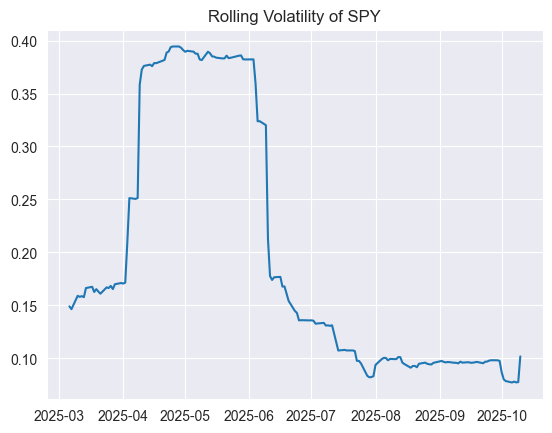

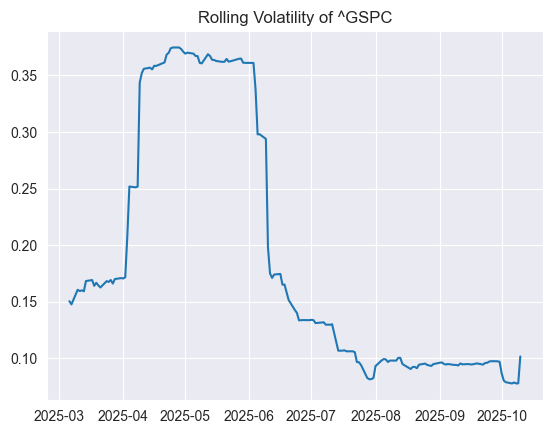

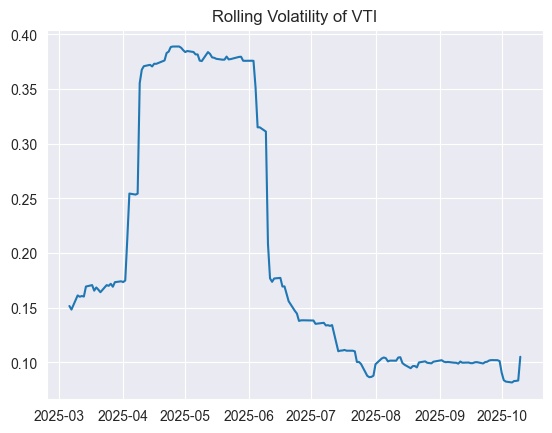

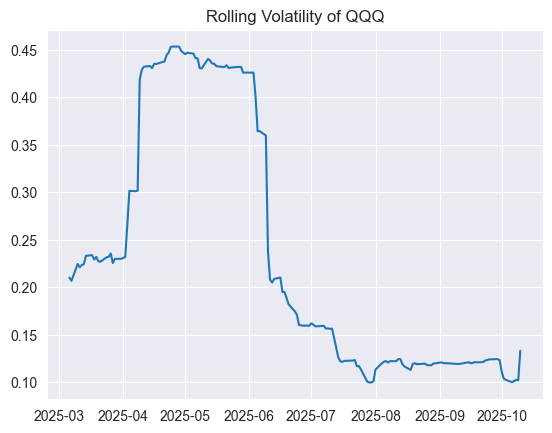

In [19]:
for ticker in tickers:

    rolling_vols = stock_data['volatility',ticker].dropna()

    plt.plot(rolling_vols)
    
    
    plt.title(f'Rolling Volatility of {ticker}')
    plt.show()

In [21]:
#Investigate Delta Hedging on real stock data using Black-Scholes values for Delta

for ticker in tickers:
    stock_data['log_returns', ticker] = np.log(stock_data['Close', ticker].pct_change()+1)
    stock_data['volatility', ticker] = stock_data['log_returns', ticker].rolling(window = 21).std()*np.sqrt(252)
    stock_data['time_to_expiration', ticker] = (stock_data.index[-1] - stock_data.index).total_seconds()/(60*60*24*365)
    
    K = int(stock_data['Close', ticker].iloc[21])

    stock_data['delta',ticker] = np.nan

    mask = stock_data.index[21:]

    stock_data.loc[mask,('delta', ticker)] = bs_call_delta(
        stock_data.loc[mask, ('Close', ticker)],
        K,
        stock_data.loc[mask, ('volatility', ticker)],
        stock_data.loc[mask, ('time_to_expiration', ticker)],
        0)
    final_stock_price = stock_data['Close',ticker].iloc[-1]
    
    call_payout = np.maximum(final_stock_price - K, 0)
    
    hedge_pnl = np.sum(stock_data['Close',ticker].diff()*\
                stock_data['delta',ticker].shift(1))

    call_pay_hedged = call_payout - hedge_pnl


    black_scholes_price = bs_call(
    stock_data['Close', ticker].iloc[21],
    K,
    stock_data['volatility', ticker].iloc[21],
    stock_data['time_to_expiration', ticker].iloc[21],
    0
    )
    
    print(f'{ticker} Black-scholes price: ${black_scholes_price:.2f}')
    
    
    print(f'{ticker} Call option value on historical data with delta hedging ${call_pay_hedged:.2f}')
    
    print('-'*(100))

AAPL Black-scholes price: $24.66
AAPL Call option value on historical data with delta hedging $25.84
----------------------------------------------------------------------------------------------------
TSLA Black-scholes price: $68.59
TSLA Call option value on historical data with delta hedging $64.94
----------------------------------------------------------------------------------------------------
F Black-scholes price: $1.19
F Call option value on historical data with delta hedging $1.29
----------------------------------------------------------------------------------------------------
HD Black-scholes price: $27.97
HD Call option value on historical data with delta hedging $27.05
----------------------------------------------------------------------------------------------------
GM Black-scholes price: $7.63
GM Call option value on historical data with delta hedging $5.95
----------------------------------------------------------------------------------------------------
SPY Blac

### Lesson to be learned

Black-Scholes assumptions are wildly inaccurate in comparison to real data. However, even the most naive version of Delta hedging can do reasonably well in comparison to Black-Scholes prices. From the point of view of a market maker, being able to sell option contracts at a premium that significantly exceeds the option payout minus the stock profits from delta hedging can lead to significant and consistent earnings.

More sophisticated modeling techniques have the potential to produce robust hedging strategies that can significantly enhance a market makers opportunity to profit from selling derivative based financial instruments.